In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = '/content/drive/MyDrive/plastic_project/dataset'

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image
import os

In [ ]:
img_size = (100, 100)
batch_size = 32

# Image data generator with validation split
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Train generator includes unknown class now
train_data = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_data = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print("Class indices:", train_data.class_indices)
class_names = list(train_data.class_indices.keys())

Found 284 images belonging to 4 classes.
Found 68 images belonging to 4 classes.
Class indices: {'bottle (1)': 0, 'cans': 1, 'cups': 2, 'unknown': 3}


In [ ]:
model = models.Sequential([
    layers.Input(shape=(img_size[0], img_size[1], 1)),

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')  # output size = number of classes (including unknown)
])

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
checkpoint_path = '/content/drive/MyDrive/plastic_project/balanced_grayscale_model_with_unknown.h5'

callbacks = [
    EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),
    ModelCheckpoint(filepath=checkpoint_path, save_best_only=True)
]

In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.2414 - loss: 1.4092 - val_accuracy: 0.2615 - val_loss: 1.3483
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 26s 839ms/step - accuracy: 0.3344 - loss: 1.3094 - val_accuracy: 0.4923 - val_loss: 1.1481
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 763ms/step - accuracy: 0.5069 - loss: 1.1107 - val_accuracy: 0.4462 - val_loss: 1.2045
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5832 - loss: 1.0085 - val_accuracy: 0.6000 - val_loss: 1.1770
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 816ms/step - accuracy: 0.5908 - loss: 0.9928 - val_accuracy: 0.6154 - val_loss: 1.1090
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6589 - loss: 0.9068 - val_accuracy: 0.6308 - val_loss: 1.1191
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 846ms/step - accuracy: 0.6508 - loss: 0.8456 - val_accuracy: 0.6462 - val_loss: 1.0912
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 839ms/step - accuracy: 0.7517 - loss: 0.7827 - val_accuracy: 0.6615 - val_loss: 1.060

In [ ]:
model.save('/content/drive/MyDrive/plastic_project/final_balanced_grayscale_model_with_unknown.h5')

In [ ]:
class_names = list(train_data.class_indices.keys())
print("Class mapping:", train_data.class_indices)

Class mapping: {'bottle (1)': 0, 'cans': 1, 'cups': 2, 'unknown': 3}


In [ ]:
def load_and_predict_with_threshold(img_path, threshold=0.7):
    img = image.load_img(img_path, color_mode='grayscale', target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)[0]
    print(f"Predicted probabilities for {img_path}: {prediction}")

    max_prob = np.max(prediction)
    predicted_class_idx = np.argmax(prediction)

    # If max probability is below threshold OR predicted class is 'unknown', mark as None
    if max_prob < threshold or class_names[predicted_class_idx] == 'unknown':
        predicted_class = None
    else:
        predicted_class = class_names[predicted_class_idx]

    plt.imshow(np.array(img), cmap='gray')
    title = f"Predicted: {predicted_class}" if predicted_class else "Predicted: Non Recyclable Not Accepted"
    plt.title(title)
    plt.axis('off')
    plt.show()

    return predicted_class


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted probabilities for /content/drive/MyDrive/plastic_project/test_images/image_1.jpg: [0.897409   0.0274305  0.02541992 0.04974059]


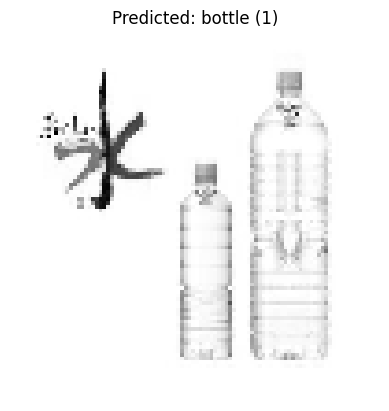

Result: bottle (1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Predicted probabilities for /content/drive/MyDrive/plastic_project/test_images/image_2.jpg: [0.00549915 0.8100425  0.04199234 0.14246595]


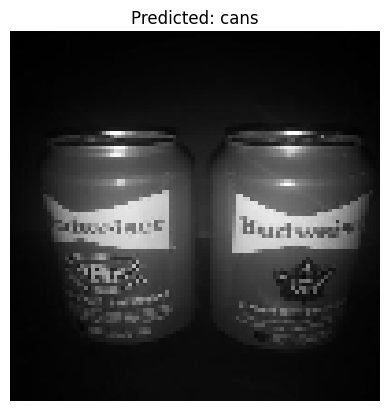

Result: cans

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Predicted probabilities for /content/drive/MyDrive/plastic_project/test_images/image_3.jpg: [0.87005633 0.06443453 0.03495189 0.0305573 ]


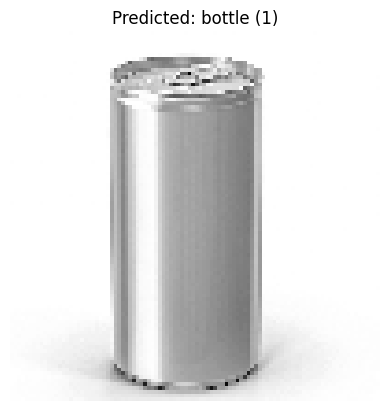

Result: bottle (1)



In [ ]:
image_paths = [
    '/content/drive/MyDrive/plastic_project/test_images/image_1.jpg',
    '/content/drive/MyDrive/plastic_project/test_images/image_2.jpg',
    '/content/drive/MyDrive/plastic_project/test_images/image_3.jpg'
]

for path in image_paths:
    predicted_label = load_and_predict_with_threshold(path, threshold=0.7)
    print(f"Result: {predicted_label}\n")

In [4]:
!mkdir -p /content/repo_upload

In [2]:
!cp /content/drive/MyDrive/plastic_project/final_balanced_grayscale_model_with_unknown.h5 /content/repo_upload/
!cp /content/grayscale_cup_classifier.ipynb /content/repo_upload/

cp: cannot stat '/content/drive/MyDrive/plastic_project/final_balanced_grayscale_model_with_unknown.h5': No such file or directory
cp: cannot stat '/content/grayscale_cup_classifier.ipynb': No such file or directory
